In [4]:
%pylab inline
import GPyOpt
import GPy
from scipy import optimize as opt
#   %pdb

Populating the interactive namespace from numpy and matplotlib


In [5]:
func  = GPyOpt.objective_examples.experiments2d.branin()

In [6]:
objective = GPyOpt.core.task.SingleObjective(func.f)

In [7]:
space = GPyOpt.Design_space(space =[{'name': 'var_1', 'type': 'discrete', 'domain': (-5,5)},
                                    {'name': 'var_2', 'type': 'discrete', 'domain': (-5,5)}])

In [8]:
model = GPyOpt.models.GPModel(optimize_restarts=5,verbose=False)

In [9]:
aquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)#, optimizer='DIRECT')

In [10]:
initial_design = GPyOpt.experiment_design.initial_design('random', space, 5)

In [11]:
from GPyOpt.acquisitions.base import AcquisitionBase
from GPyOpt.acquisitions.EI import AcquisitionEI
from numpy.random import beta

class Exp_impr(AcquisitionBase):
   
    def __init__(self, model, space, optimizer=None, cost_withGradients=None, par_a=1, par_b=1, num_samples= 10):
        super(Exp_impr, self).__init__(model, space, optimizer)
        
        self.par_a = par_a
        self.par_b = par_b
        self.num_samples = num_samples
        self.samples = beta(self.par_a,self.par_b,self.num_samples)
        self.EI = AcquisitionEI(model, space, optimizer, cost_withGradients)
        
    def compute_exp_impr(self, x):
        m, s = self.model.predict(x)
        #m, s = get_assessed_val(preds, X_test)
        fmin = self.model.get_fmin()
        phi, Phi, u = self.get_quantiles(self.jitter, fmin, m, s)
        f_acqu = s * (u * Phi + phi)
        cost_x, _ = self.cost_withGradients(x)
        return -(f_acqu*self.space.indicator_constraints(x))/cost_x
    
    
    def get_quantiles(acquisition_par, fmin, m, s):
    
        if isinstance(s, np.ndarray):
            s[s<1e-10] = 1e-10
        elif s< 1e-10:
            s = 1e-10
        u = (fmin - m - acquisition_par)/s
        phi = np.exp(-0.5 * u**2) / np.sqrt(2*np.pi)
        Phi = 0.5 * erfc(-u / np.sqrt(2))
        return (phi, Phi, u)
    
    def acquisition_function(self,x):
        acqu_x = np.zeros((x.shape[0],1))       
        for k in range(self.num_samples):
            self.EI.jitter = self.samples[k]
            acqu_x +=self.EI.acquisition_function(x)   #here          
        return acqu_x/self.num_samples

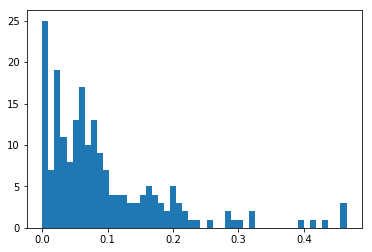

In [12]:
acquisition = Exp_impr(model, space, optimizer=aquisition_optimizer, par_a=1, par_b=10, num_samples=200)
xx = plt.hist(acquisition.samples,bins=50)

In [13]:
# --- CHOOSE a collection method
evaluator = GPyOpt.core.evaluators.Sequential(acquisition)

In [21]:
bo = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)
#bo2 = GPyOpt.methods.ModularBayesianOptimization(model, space, objective, acquisition, evaluator, initial_design)


In [27]:
bounds =[{'name': 'var_1', 'type': 'continuous', 'domain': (-5, 5)},
         {'name': 'var_2', 'type': 'continuous', 'domain': (-5 ,5)}]

branin  = GPyOpt.objective_examples.experiments2d.branin()

bo2 = GPyOpt.methods.BayesianOptimization(branin.f,
                                              domain=bounds,
                                              model_type = 'GP',
                                              acquisition_type='EI',  
                                              normalize_Y = True,
                                              acquisition_weight = 2)    

In [28]:
max_iter  = 10      
max_time = 120     # time budget 
bo.run_optimization(max_iter = 6) 

bo2.run_optimization(max_iter = 5)

In [60]:
def new_plot_convergence(ModularBayesianOptimization, BayesianOptimization, filename = None):
    
    n = bo.X.shape[0]
    m = bo2.X.shape[0]
    
    plt.subplot(1, 1, 1)
    
    plt.plot(list(range(n)), bo.Y_best,'-o')
    plt.plot(list(range(m)), bo2.Y_best,'-o')

    
    plt.title('Value of the best selected sample')
    plt.xlabel('Iteration')
    plt.ylabel('Best y')
    grid(True)

    if filename!=None:
        savefig(filename)
    else:
        plt.show()

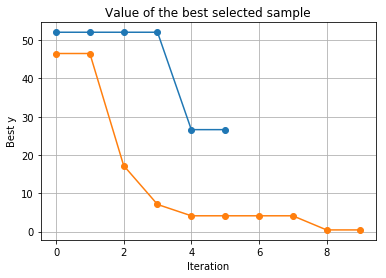

In [61]:
new_plot_convergence(bo, bo2)

In [37]:
myProblem.x_opt

myProblem.fx_opt

NameError: name 'myProblem' is not defined

In [22]:
bo.plot_acquisition()
bo.plot_convergence()

AttributeError: 'OptDirect' object has no attribute 'space'